# Looking into using backpropagation to determine sensitivities 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm

import glob
import torch

In [2]:
from basicModel import EstimateAngle_Faces_final, EstimateAngle_Faces
from datageneration.faces.rotated_olivetti import FaceDataset

ckpt = 'trainedParameters/Exp8/dropout/linear/low_conc/rep0/epoch=571-step=146432.ckpt'
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

In [3]:
test_data = FaceDataset(torch.linspace(0., 0., 500), split='test')
images = test_data.images.contiguous()

## What is the difference in ouput variance with dropout on/off?

In [4]:
dropout_on = model.forward(images.to(model.device)).cpu().detach()
model.eval()
dropout_off = model.forward(images.to(model.device)).cpu().detach()

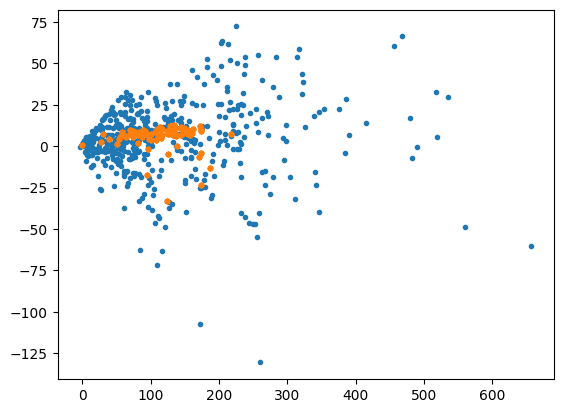

In [5]:
plt.plot(dropout_on[:,0], dropout_on[:,1], '.')
plt.plot(dropout_off[:,0], dropout_off[:,1], '.')

#### Interesting

Keeping the dropout on of course results in a larger spread of outputs.

This spread is particularly noticable in that it also runs perpendicular to the main component with dropout frozen, meaning that it will certainly impact the Fisher information.

## Comparison between output differences and derivatives

In [6]:
test_data = FaceDataset(torch.concat([torch.zeros(80), torch.zeros(80)-0.05, torch.zeros(80)+0.05]),
                        split='test')
images = test_data.images.contiguous()

In [7]:
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
model.eval()
zero_enc = model.forward(images[0:1].to(model.device))
zero_enc

tensor([[135.5307,   8.0452]], device='mps:0', grad_fn=<LinearBackward0>)

In [8]:
minus_enc = model.forward(images[80:81].to(model.device))
plus_enc = model.forward(images[160:161].to(model.device))
minus_enc

tensor([[140.1786,   5.5148]], device='mps:0', grad_fn=<LinearBackward0>)

In [9]:
(plus_enc - minus_enc)

tensor([[-13.5145,   4.6594]], device='mps:0', grad_fn=<SubBackward0>)

In [10]:
model.model

Sequential(
  (0): Linear(in_features=4096, out_features=30, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=30, out_features=10, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=10, out_features=2, bias=True)
)

In [11]:
zero_enc

tensor([[135.5307,   8.0452]], device='mps:0', grad_fn=<LinearBackward0>)

In [12]:
# very dirty for now
zero_img = images[0:1].to(model.device)
zero_img.requires_grad = True
zero_enc = model.forward(zero_img)

grad_0 = torch.autograd.grad(zero_enc[0,0], zero_img, retain_graph=True)[0].cpu()
grad_1 = torch.autograd.grad(zero_enc[0,1], zero_img, retain_graph=True)[0].cpu()

d_img = images[80:81] - images[160:161]

In [13]:
(d_img * grad_0).sum()

tensor(13.7481)

In [14]:
(d_img * grad_1).sum()

tensor(-4.9759)

Ok nice. In this case, these approaches give broadly the same answer.

### Using the vector-jacobian interface

In [15]:
torch.eye(2)[0:1,:]

tensor([[1., 0.]])

In [16]:
vj_grad_0 = torch.autograd.functional.vjp(model, zero_img.to(model.device), torch.eye(2)[0:1,:].to(model.device))
vj_grad_1 = torch.autograd.functional.vjp(model, zero_img.to(model.device), torch.eye(2)[1:2,:].to(model.device))

In [17]:
(vj_grad_0[1].cpu() == grad_0.cpu()).all()

tensor(True)

In [18]:
(vj_grad_1[1].cpu() == grad_1.cpu()).all()

tensor(True)

### Lets try it with multiple samples

In [19]:
def make_images(angle):
    dataset = FaceDataset(torch.zeros(80) + angle, split='test')
    return dataset.images.contiguous()

img_0 = make_images(0.)
img_minus = make_images(-0.05)
img_plus = make_images(0.05)

In [20]:
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
model.eval()

outputs_0 = model.forward(img_0.to(model.device)).cpu()
outputs_minus = model.forward(img_minus.to(model.device)).cpu()
outputs_plus = model.forward(img_plus.to(model.device)).cpu()

cov = torch.cov(outputs_0.T)

Simple differencing approach: inner produce of the difference between the output vectors

In [21]:
# difference between foreward inputs
delta = (outputs_plus - outputs_minus).mean(axis=0)
delta @ torch.linalg.inv(cov) @ delta

tensor(0.9071, grad_fn=<DotBackward0>)

Differences that project along the eigenvalues.

In [30]:
icov_eig = torch.linalg.eig(torch.linalg.inv(cov))

eig_vec = icov_eig.eigenvectors.real
eig_val = icov_eig.eigenvalues.real


In [37]:
(delta @ eig_vec[:, 0])**2 * eig_val[0] +  (delta @ eig_vec[:, 1])**2 * eig_val[1]

tensor(0.9071, grad_fn=<AddBackward0>)

In [47]:
backward_eigv1 = torch.autograd.functional.vjp(model, img_0.to(model.device), eig_vec[:, 0].to(model.device))

RuntimeError: v has invalid size: should be torch.Size([80, 2]) but got torch.Size([2]).

Hold on a second. This requires that we do backward differentiation for every replicate! It will be massively slow compared to the alternative!

#### Why are we doing this again?

Answer: the whole purpose of this approach, diagonalizing the matrix etc, is to deal with high-dimensional neural representations of low dimensional spaces by approximating the covariance matrix with only the highest (or maybe lowest) N components of the covariance matrix.
Assuming that this can be accomplished without full diagonalization, this will save on the N^3 inversion.

That is to say, we want $dx^T C^{-1} dx$ without inverting $C$.

#### Is there a benefit of differentiating later?

The above is all good, but I can still use output differences or input differences to do the differentiation. Thats what I should be testing here.

#### HMMM.

In fact, this approach is calibrated to handle high _stimulus_ dimensions relative to the dimension of the neural encoding .

In our case, the representation dimension is tiny compared to the pixel dimension, so this would make sense. However, we care about derivatives relative to a one-dimensional input parameter, so that consideration doesn't really matter for this case.

## I'm still struggling with how to handle the slow and noisy FI measurements.

How noisy are the results with dropout on?

In [248]:
def make_images(angle):
    dataset = FaceDataset(torch.zeros(800) + angle, split='test')
    return dataset.images.contiguous()



model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

In [245]:
def FI(angle):
    img_0 = make_images(angle)
    img_minus = make_images(angle-0.05)
    img_plus = make_images(angle+0.05)
    outputs = model.forward(img_0.to(model.device)).cpu()
    
    cov = outputs.T.cov()

    dT = model.forward(img_plus.to(model.device)).mean(0) - model.forward(img_minus.to(model.device)).mean(0)
    dT = dT.cpu()
    return dT @ torch.linalg.inv(cov) @ dT

#### Bug report 

Taking covariance on the gpu results in incorrect (0) covariance.

To do: I need to simplify this down to a simple reproducible example

In [210]:
inputs = img_0

In [214]:
outs = model.forward(inputs.to(model.device))
print(outs.T.cov())

tensor([[0., 0.],
        [0., 0.]], device='mps:0', grad_fn=<SqueezeBackward0>)


In [216]:
outs = model.forward(inputs.to(model.device))
print(outs)
outs.T.cov()

tensor([[ 1.6689e+02, -5.4895e+00],
        [-1.7073e-03,  9.8859e-01],
        [ 1.0397e+02,  8.0771e+00],
        ...,
        [ 3.9415e+01, -8.6788e+00],
        [ 2.0440e+02,  8.8992e+00],
        [ 4.1471e+01,  2.7935e+00]], device='mps:0', grad_fn=<LinearBackward0>)


tensor([[9806.9766,  341.7476],
        [ 341.7476,  517.2352]], device='mps:0', grad_fn=<SqueezeBackward0>)

In [217]:
outs = model.forward(inputs.to(model.device)).detach().cpu()

In [218]:
outs.T.cov()

tensor([[10635.4209,   568.0593],
        [  568.0593,   535.8842]])

#### Continuing on.

In [254]:
angles = np.linspace(0, 2*np.pi, 300)
FIs = []
for i, angle in enumerate(angles):
    if i % 20 == 0:
        print(i)
    FIs.append(FI(angle).item())

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280


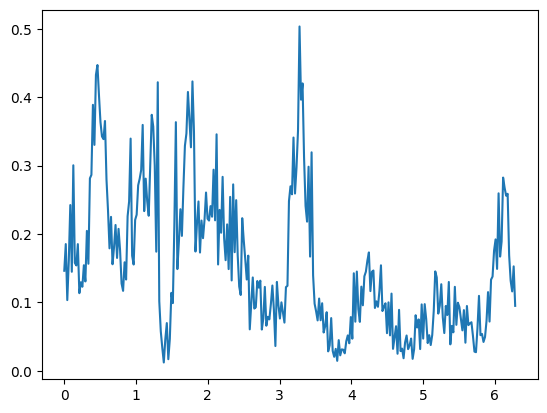

In [255]:
plt.plot(angles, np.array( FIs))

### What we really care about

Are the noise properties of these estimators with respect to scaling the numbers of inputs that we use to determine the mean and covariance.

Is either approach better in terms of noise?

## Lets step back even further: Fisher info estimation for a simple problem

In [181]:
# very simple set-up
from fisher_info_tests import *
%run fisher_info_tests.py

thetas = np.linspace(0, 2*np.pi)

xs = np.stack([np.cos(thetas), np.sin(thetas)]).T

mean = mean_traj(thetas, xs)
cov = constant_cov( np.array( [[1, 0.5],[0.5, 2]]))

<Figure size 640x480 with 0 Axes>

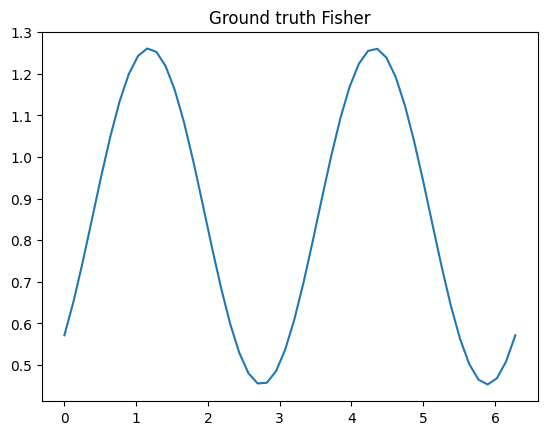

In [15]:
gts = []
for theta in thetas:
    gts.append( FI_ground_truth(theta, mean, cov) )

plt.plot(thetas, np.array(gts))
plt.title('Ground truth Fisher');

It looks this way because the covariance matrix is not identity, so FI changes as the angle relative to this covariance matrix changes. 

In [51]:
s_pre = generate_samples(0 - 0.05, mean, cov, N=100)
s_post = generate_samples(0 + 0.05, mean, cov, N=100)

In [52]:
(s_pre.mean(0) - s_post.mean(0)) / 0.1

array([-0.8665518 ,  2.55666436])

In [53]:
mean.derivative()(0)

array([1.94289029e-16, 9.99998495e-01])

In [55]:
np.cov(s_pre.T)

array([[1.04850059, 0.78615299],
       [0.78615299, 1.93460546]])

Ok, this is a major problem with evaluating derivatives on the small scale: the number of samples that we need to get a good estimate of means can be large.

Standard error scales with the square-root of the number of samples.

In [68]:
#How many samples do we need?

(max(np.diag( cov(0) )) / 0.01 )**2

40000.0

In [100]:
s_pre = generate_samples(0 - 0.05, mean, cov, N=40000)
s_post = generate_samples(0 + 0.05, mean, cov, N=40000)

print('pre:', s_pre.mean(0))
print('post:', s_post.mean(0))


pre: [ 0.99785507 -0.06452682]
post: [0.99637405 0.04319754]


In [101]:
(s_post.mean(0) - s_pre.mean(0)) / 0.1

array([-0.01481021,  1.0772436 ])

In [102]:
mean.derivative()(0)

array([1.94289029e-16, 9.99998495e-01])

Ok, this scaling is about right. The problem is that it is also totally impractical. Especially with the level of covariance that we are seeing in our network outputs.

We'll need tens of thousands of samples.

In [130]:
ckpt = 'trainedParameters/Exp8/dropout/linear/low_conc/rep0/epoch=571-step=146432.ckpt'
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

test_data = FaceDataset(torch.zeros(1000), split='test')
images = test_data.images.contiguous()

outputs= model.forward(images.to(model.device)).cpu().detach()

In [131]:
outputs.T.cov()

tensor([[11020.8320,   285.4301],
        [  285.4301,   454.9617]])

In [135]:
outputs.mean(0)

tensor([115.9337,   4.4260])

In [140]:
test_data2 = FaceDataset(torch.zeros(1000), split='test')
images2 = test_data2.images.contiguous()

outputs2= model.forward(images2.to(model.device)).cpu().detach()

In [141]:
outputs2.mean(0)

tensor([111.4276,   4.0702])

Differences look to be about size 1.

In [129]:
(11020 / 1.)**2

121440400.0

#### One consideration, however
The variance due to different test set images may be very different from the variation that results from resampling the network.

In [213]:
test_data = FaceDataset(torch.zeros(80), split='test')
images = test_data.images.contiguous()
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

In [235]:
image_repeat = images[0:1].repeat((500,1,1)).to(model.device)
same_image = model.forward(image_repeat).cpu()

In [236]:
same_image.T.cov()

tensor([[12314.1523,   401.5663],
        [  401.5663,   506.3860]], grad_fn=<SqueezeBackward0>)

In [240]:
# empirical covariance of the estimate
outs = []

for i in range(200):
    repeats = model.forward(image_repeat).cpu()
    outs.append(repeats.mean(0))

In [242]:
torch.stack(outs).T.cov()

tensor([[22.0535,  0.8577],
        [ 0.8577,  1.0258]], grad_fn=<SqueezeBackward0>)

In [245]:
same_image.T.cov() / 500**0.5

tensor([[550.7056,  17.9586],
        [ 17.9586,  22.6463]], grad_fn=<DivBackward0>)

In [246]:
same_image.T.cov() / 500

tensor([[24.6283,  0.8031],
        [ 0.8031,  1.0128]], grad_fn=<DivBackward0>)

Hmmmm. Why does the covariance look like it scales with $N$ rather than $\sqrt{N}$? This would seem to indicate some non-normality of the data.

__Ans:__ Actually, it should. SEM has exactly this $1/N$ mean scaling, with root for standard deviation, of course.

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

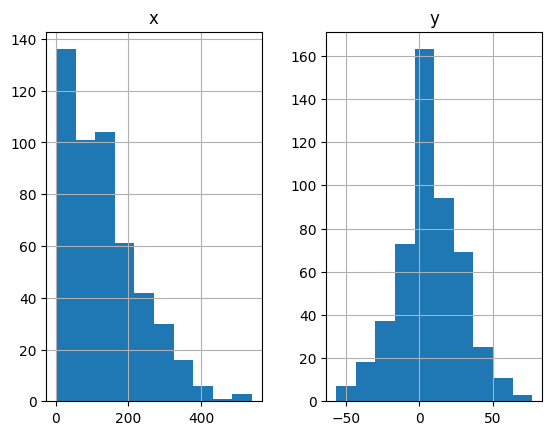

In [263]:
pd.DataFrame(data=repeats.detach(), columns=['x', 'y']).hist(['x','y'])

Huh, why is `x` restricted to be positive?

In [293]:
data_1 = FaceDataset(torch.zeros(80)+np.pi/4, split='test')
images_1 = data_1.images.contiguous()

image_repeat = images_1[0:1].repeat((500,1,1)).to(model.device)
same_image = model.forward(image_repeat).cpu()

outputs = pd.DataFrame(data=same_image.detach(), columns=['x', 'y'])

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

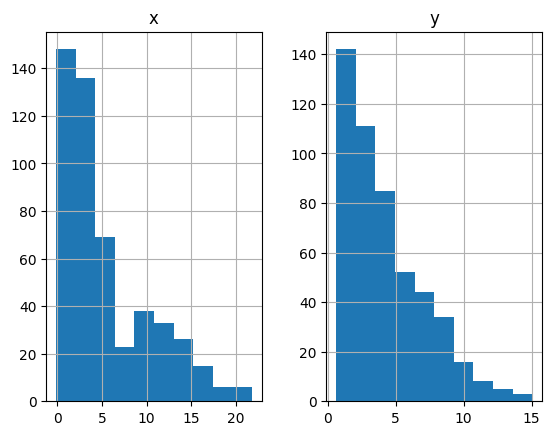

In [294]:
outputs.hist(['x','y'])

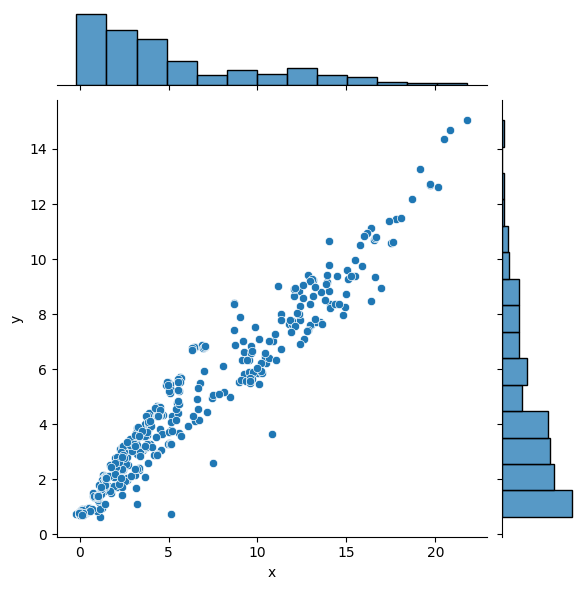

In [295]:
sns.jointplot(data=outputs, x='x', y='y')

Ok, yes. This does make sense. The data-points are roughly clustered around the unit circle, so they can be all positive in one dimension, while balanced in another.

#### Distribution of means

Text(0.5, 0.98, 'Distribution of means')

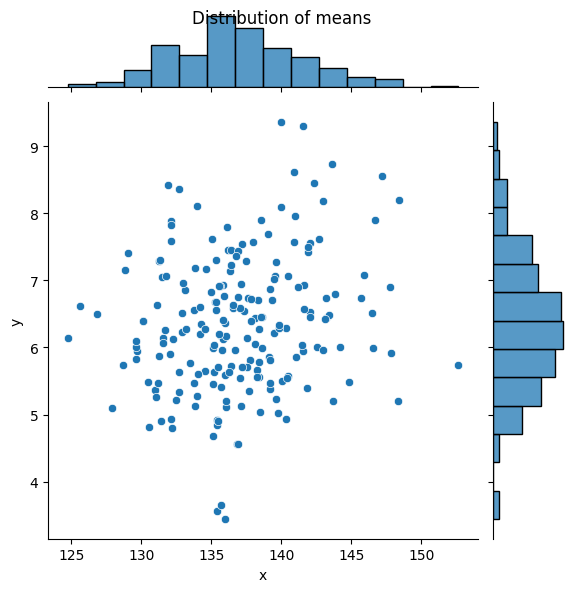

In [304]:
means = pd.DataFrame(data=torch.stack(outs).detach(), columns=['x', 'y'])

sns.jointplot(data=means, x='x', y='y')
plt.suptitle('Distribution of means')

It is a bit less correlated than I would have expected.

### Within image vs between image variance

In [90]:
test_data = FaceDataset(torch.zeros(80*80), split='test')
images = test_data.images.contiguous()

all_outputs = model.forward(images.to(model.device)).detach().cpu()

data = pd.DataFrame({'x': all_outputs[:,0], 'y': all_outputs[:,1], 'image_id': torch.arange(80).repeat(80)})

In [5]:
sm.stats.anova_lm( smf.ols('x ~ C(image_id)', data).fit() )

,df,sum_sq,mean_sq,F,PR(>F)
C(image_id),79.0,1.207645e+07,152866.423755,17.225211,6.317145e-208
Residual,6320.0,5.608731e+07,8874.575035,NaN,NaN


In [6]:
sm.stats.anova_lm( smf.ols('y ~ C(image_id)', data).fit() )

,df,sum_sq,mean_sq,F,PR(>F)
C(image_id),79.0,3.505887e+05,4437.831289,10.651784,1.053814e-118
Residual,6320.0,2.633089e+06,416.627989,NaN,NaN


Ok, there is substantial additional variance between images as compared to across images. This is not surprising, but it should also place a limit on the degree to which we can improve the estimated variance.

<Axes: xlabel='x', ylabel='y'>

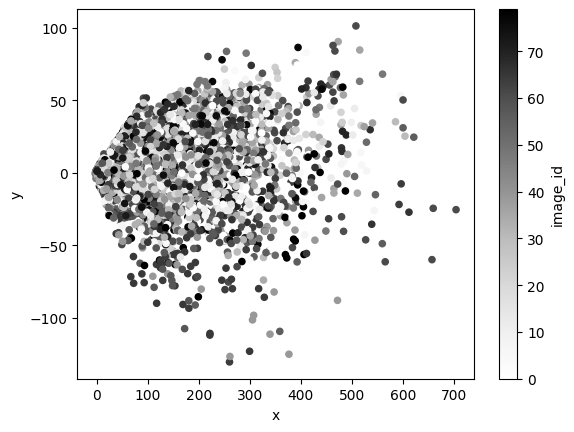

In [7]:
data.plot.scatter(x='x', y='y', c='image_id')

Hard to see much sub-structure in this plot. That doesn't mean that it's not there though.

### Bootstrap variance estimation.

In [91]:
from scipy.stats import bootstrap

img_plus = FaceDataset(torch.zeros(80*80)+0.1, split='test')
img_plus = img_plus.images.contiguous()
outputs_plus = model.forward(img_plus.to(model.device)).detach().cpu()


In [92]:
all_outputs = all_outputs.numpy()
outputs_plus = outputs_plus.numpy()

In [93]:
def difference(x1, x2, axis=1):
    return np.mean(x2, axis=axis) - np.mean(x1, axis=axis)
    
bootstrap((all_outputs[:,0], outputs_plus[:,0]), difference)

BootstrapResult(confidence_interval=ConfidenceInterval(low=-19.39844169270412, high=-12.885536692348625), bootstrap_distribution=array([-13.284882, -12.93338 , -13.452461, ..., -15.946671, -15.086533,
       -17.629028], dtype=float32), standard_error=1.666536)

Nice, here we're estimating confidence intervals / standard error on the the deltas

In [109]:
estimates = []

for i in range(100):
    img_plus = FaceDataset(torch.zeros(80*80)+0.05, split='test').images.contiguous()
    img_minus = FaceDataset(torch.zeros(80*80)-0.05, split='test').images.contiguous()
    
    outputs_plus = model.forward(img_plus.to(model.device)).detach().cpu()
    outputs_minus = model.forward(img_minus.to(model.device)).detach().cpu()
    
    delta = (outputs_plus.mean(0) - outputs_minus.mean(0))
    cov = torch.concat([outputs_plus, outputs_minus]).T.cov()
    
    estimates.append(delta @ torch.linalg.inv(cov) @ delta)
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


(array([12., 14., 18., 17., 12., 18.,  4.,  4.,  0.,  1.]),
 array([1.08301842, 1.13268363, 1.18234897, 1.23201418, 1.28167939,
        1.3313446 , 1.38100994, 1.43067515, 1.48034036, 1.53000569,
        1.57967091]),
 <BarContainer object of 10 artists>)

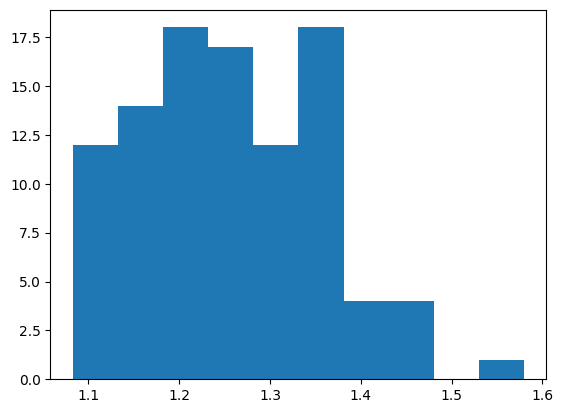

In [114]:
plt.hist(torch.stack(estimates) / 0.1)

## Lets try it with multiple Fisher information points

In [207]:
# very simple set-up
from fisher_info_tests import *
%run fisher_info_tests.py

thetas = np.linspace(0, 2*np.pi)

xs = np.stack([np.cos(thetas), np.sin(thetas)]).T

mean = mean_traj(thetas, xs)
cov = constant_cov( np.array( [[1, 0.5],[0.5, 2]]))

<Figure size 640x480 with 0 Axes>

In [292]:
def simple_FI(center, diff=0.05, reps=6000):
    mean = mean_traj(thetas, xs)
    cov = constant_cov( np.array( [[1, 0.5],[0.5, 2]]))

    outs_plus = generate_samples(center + diff, mean, cov, reps)
    outs_minus = generate_samples(center - diff, mean, cov, reps)

    deriv = (outs_plus.mean(0) - outs_minus.mean(0)) / (2*diff)
    cov = np.cov( np.concatenate([outs_plus, outs_minus]).T)
    
    return deriv @ np.linalg.inv(cov) @ deriv


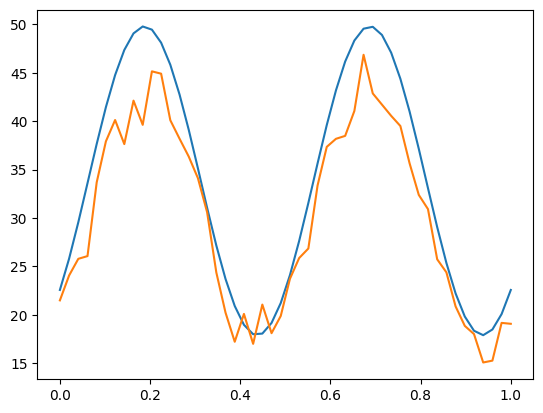

In [239]:
gts = []
fits = []

thetas = np.linspace(0, 1, 50)

for theta in thetas:
    gts.append( FI_ground_truth(theta, mean, cov) )
    fits.append( simple_FI(theta) )

plt.plot(thetas, np.array(gts))
plt.plot(thetas, fits)

Ok, so I think I see some of the bias playing out in this particular case.

In [272]:
def bias_corrected(center, diff=0.05, reps=6000):
    mean = mean_traj(thetas, xs)
    cov = constant_cov( np.array( [[1, 0.5],[0.5, 2]]))

    outs_plus = generate_samples(center + diff, mean, cov, reps)
    outs_minus = generate_samples(center - diff, mean, cov, reps)

    deriv = (outs_plus.mean(0) - outs_minus.mean(0)) / (2*diff)
    cov = np.cov( np.concatenate([outs_plus, outs_minus]).T)

    FI = deriv @ np.linalg.inv(cov) @ deriv * (2*reps - 2 - 3) / ( 2*reps -2) - 4/(reps*4*diff**2)
    return FI

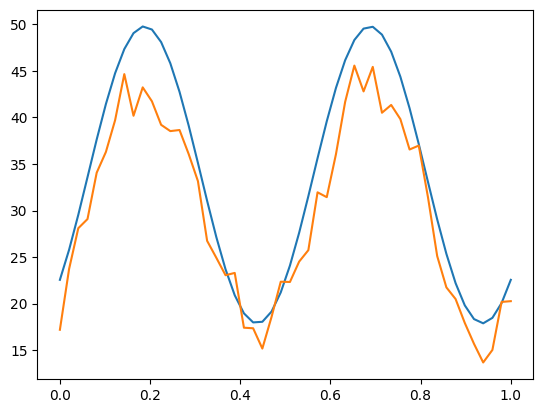

In [283]:
gts = []
fits = []

thetas = np.linspace(0, 1, 50)

for theta in thetas:
    gts.append( FI_ground_truth(theta, mean, cov) )
    fits.append( simple_FI(theta ))

plt.plot(thetas, np.array(gts))
plt.plot(thetas, fits)

Hmmmm. That doesn't seem to make a difference

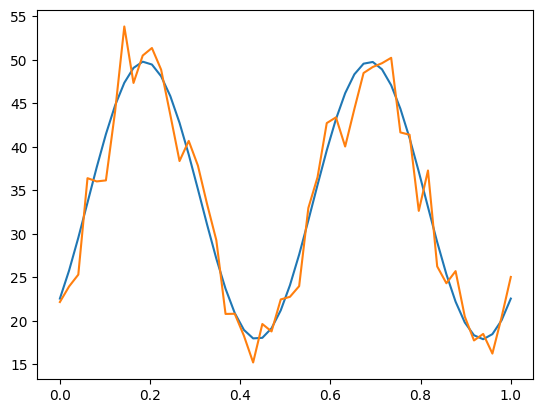

In [287]:
gts = []
fits = []

thetas = np.linspace(0, 1, 50)

for theta in thetas:
    gts.append( FI_ground_truth(theta, mean, cov) )
    fits.append( simple_FI(theta, diff=0.01, reps=100000) )

plt.plot(thetas, np.array(gts))
plt.plot(thetas, fits)

#### Ok, here's what I'm seeing:

Essentially, the bias correction doesn't matter. Instead, the limiting factors seem to be:
1. The size of the finite differences that we estimate over
2. The number of samples that we use.

Note that the first factor drives the second because smaller deltas also require better resolution, which in turn requires more samples.

### Same thing with the trained network

In [297]:
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))


def simple_FI_model(center, diff=0.05, reps=80):
    img_plus = FaceDataset(torch.zeros(80*reps) + center - diff,
                           split='test'
                          ).images.contiguous()
    img_minus = FaceDataset(torch.zeros(80*reps) + center + diff,
                            split='test'
                           ).images.contiguous()


    outs_plus = model.forward(img_plus.to(model.device)).detach().cpu()
    outs_minus = model.forward(img_plus.to(model.device)).detach().cpu()

    deriv = (outs_plus.mean(0) - outs_minus.mean(0)) / (2*diff)  
    cov = torch.concat([outs_plus, outs_minus]).T.cov() 
    
    return deriv @ torch.linalg.inv(cov) @ deriv


0
5
10
15
20


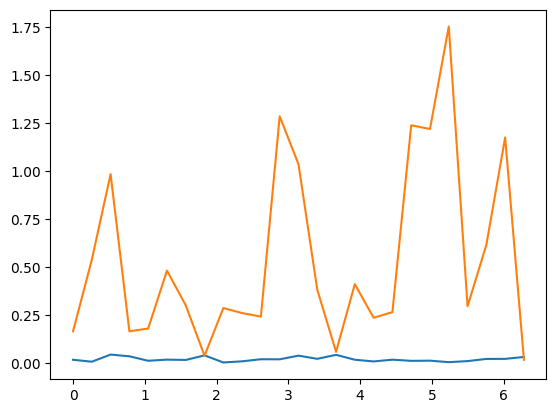

In [299]:
bigger_diff = []
smaller_diff = []

thetas = np.linspace(0, 2*np.pi, 25)

for i, theta in enumerate(thetas):
    bigger_diff.append( simple_FI_model(theta, diff=0.05, reps=200)  )
    smaller_diff.append( simple_FI_model(theta, diff=0.01, reps=200) )

    if i % 5 == 0:
        print(i)

plt.plot(thetas, bigger_diff)
plt.plot(thetas, smaller_diff)

Hmmm. It's hard to tell what this means: is it that derivative is poorly evaluated? Or just under sampled?

Another possibility: it could be that the image differences are non-linear in angle differences. Eg: Pixel-wise differences may shrink non-linearly as angular differences go to zero. 

#### How does the mean square pixel difference depend on the angular difference?

In [633]:
diffs = np.logspace(-1, -2, 15)
msi_diff = []

for d in diffs:
    plus_I0 = FaceDataset(torch.zeros(80) + d/2, split='test').images[0:1]
    minus_I0 = FaceDataset(torch.zeros(80) - d/2, split='test').images[0:1]
    
    msi_diff.append( ((plus_I0 - minus_I0)**2).mean() )

Text(0.5, 1.0, 'image vs angle differences')

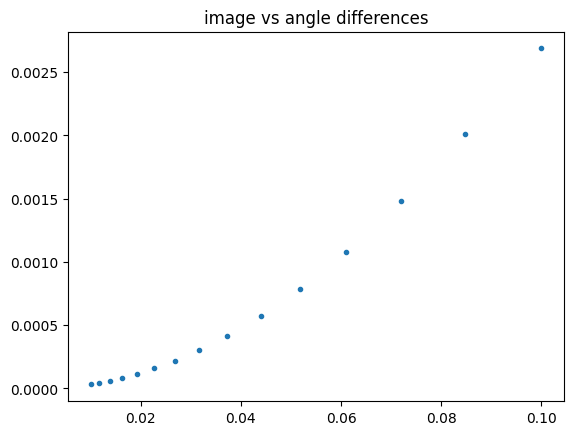

In [640]:
plt.plot(diffs, msi_diff, '.')
plt.title('image vs angle differences')

Text(0.5, 1.0, 'log-log plot')

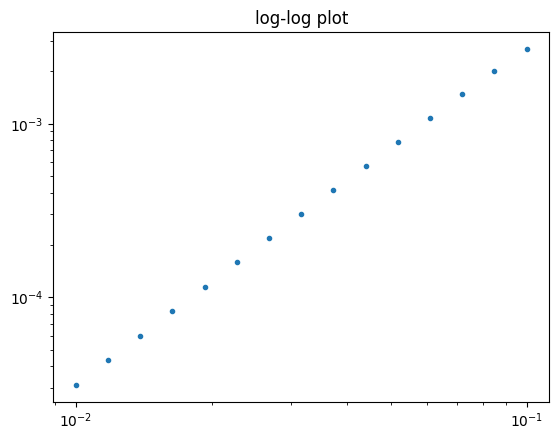

In [637]:
plt.loglog(diffs, msi_diff, '.')
plt.title('log-log plot')

This looks pretty well behaved.

## Can the model in eval mode help us evaluate averages faster?


In [317]:
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

def sample_outputs(model, reps=80):
    """  """
    model.train()
    img = FaceDataset(torch.zeros(80*reps), split='test'
                      ).images.contiguous()
    
    return model.forward(img.to(model.device)).mean(0).cpu().detach().numpy()


In [343]:
model.eval()
img_solo = FaceDataset(torch.zeros(80), split='test'
                  ).images.contiguous()

eval_outputs = model.forward(img_solo.to(model.device)).mean(0).cpu().detach().numpy()

In [344]:
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

samples = []
for rep in range(250):
    samples.append(sample_outputs(model, reps=100))

    if rep % 25 == 0:
        print(rep)

samples = np.array(samples)

0
25
50
75
100
125
150
175
200
225


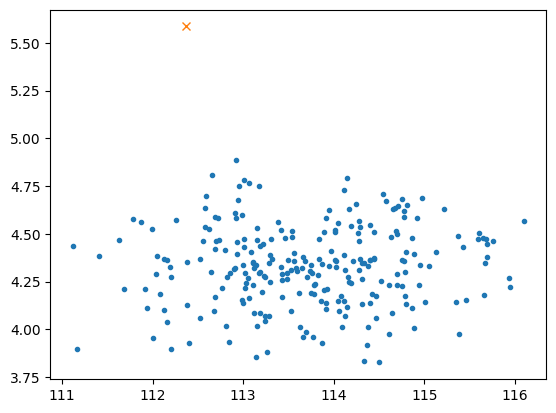

In [345]:
plt.plot(samples[:,0], samples[:,1], '.')
plt.plot(eval_outputs[0], eval_outputs[1], 'x')

#### Answer: no.
This doesn't work. The output at eval time is very different from the sampled average output.

## Derivatives

Can these be more _sample efficient_ than the finite differences?
That is to say, if we take derivatives through the network can we get less variable derivative estimates than output finite differences?

### First test: average of derivatives vs derivative of average.

In [487]:
# limit ourselves to only one baseline image.
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
dataset = FaceDataset(torch.zeros(80),split='test')

I0 = dataset.images[0:1].repeat((80, 1, 1))
I0.requires_grad = True

In [488]:
outputs = model.forward(I0.to(model.device))

In [531]:
# take derivatives of the average output.
avg_then_deriv = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]

In [532]:
derivs = []

for rep in range(80):
    derivs.append( torch.autograd.grad(outputs[rep, 0], I0, retain_graph=True)[0] )

deriv_then_avg = torch.stack(derivs).mean(0)

In [533]:
(avg_then_deriv == deriv_then_avg).all()

tensor(False)

This is surprising because each individual derivative only sees one input image, as we would expect.

In [534]:
torch.abs(deriv_then_avg - avg_then_deriv).max()

tensor(2.9802e-08)

I think it's actually just the round-off / low precision.

In [535]:
torch.abs(( (deriv_then_avg - avg_then_deriv) / avg_then_deriv)).max()

tensor(0.0618)

In [536]:
torch.abs(( (deriv_then_avg - avg_then_deriv) / deriv_then_avg)).max()

tensor(0.0659)

Ok, so they differ by at most 6%. Its a little big for my liking, but:

In [537]:
argmax = torch.abs(( (deriv_then_avg - avg_then_deriv) / avg_then_deriv)).argmax()
print(deriv_then_avg.view(-1)[argmax])
print(avg_then_deriv.view(-1)[argmax])

tensor(2.1383e-09)
tensor(2.2792e-09)


However, that is at a place where the values themselves are very close to zero, so I'm ok with it.

#### Conclusion: averaging before / after derivatives results in small changes, likely due to round-off

### Second test: averaging derivatives across replicates vs differentiation wrt one input

Before we were looking at averaging in output space. What about sharing input space?

In [575]:
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
dataset = FaceDataset(torch.zeros(80),split='test')

# Are we tracking the derivatives for each replicate or overall?
I0_singular = dataset.images[0:1]
I0_singular.requires_grad = True

I0_repeated = I0_singular.repeat((80, 1, 1))

outputs = model.forward(I0_repeated.to(model.device))

In [576]:
repeats_grad = torch.autograd.grad(outputs.mean(0)[0], I0_repeated, retain_graph=True)[0]
single_grad = torch.autograd.grad(outputs.mean(0)[0], I0_singular, retain_graph=True)[0]

In [577]:
single_grad - repeats_grad.mean(0)

tensor([[[-0.0297, -0.0097,  0.0056,  ..., -0.0072,  0.0154,  0.0168],
         [-0.0407,  0.0015, -0.0309,  ..., -0.0254, -0.0147, -0.0086],
         [-0.0295, -0.0047, -0.0039,  ..., -0.0075, -0.0070, -0.0240],
         ...,
         [-0.0169, -0.0050, -0.0315,  ..., -0.0170, -0.0120, -0.0194],
         [-0.0190, -0.0439, -0.0260,  ..., -0.0171,  0.0139, -0.0348],
         [-0.0378, -0.0204, -0.0134,  ..., -0.0373, -0.0175, -0.0122]]])

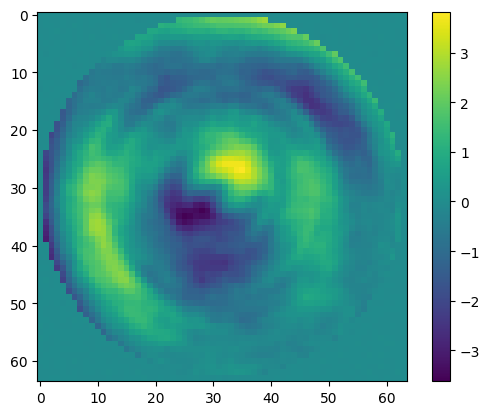

In [578]:
plt.imshow(single_grad[0])
plt.colorbar()

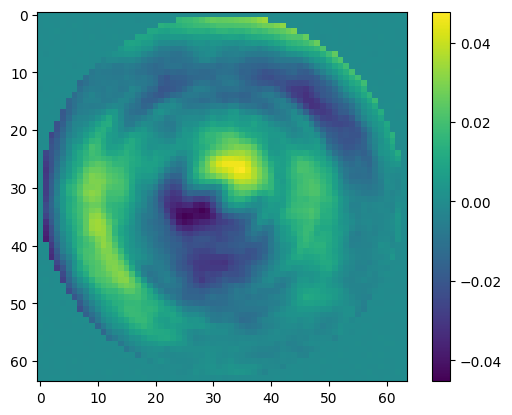

In [579]:
plt.imshow(repeats_grad.mean(0))
plt.colorbar()

Ok, so they're not equal, but they sure look similar. The main difference is the difference in magnitude.

In [574]:
(single_grad == repeats_grad.sum(0)).all()

tensor(True)

Ok, it's the sum, not the mean. Totally makes sense.

Also note that we get a resonable orintation sensative receptive field, which is totally cool!

#### conclusion: derivatives wrt a shared input work just fine.

### Part 3: noise level of derivatives estimated this way.

In [641]:
d = 0.1
plus_I0 = FaceDataset(torch.zeros(80) + d/2, split='test').images[0:1]
minus_I0 = FaceDataset(torch.zeros(80) - d/2, split='test').images[0:1]

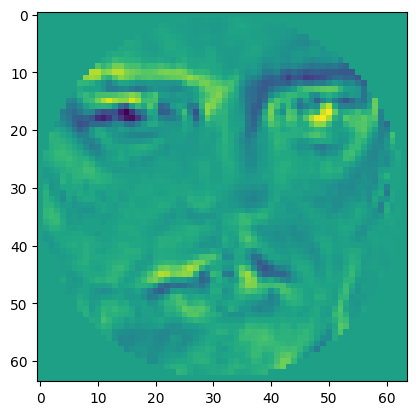

In [643]:
plt.imshow(plus_I0[0] - minus_I0[0])

:O

First, we need multiple estimates of the derivatives.

In [681]:
def estimate_deriv(size, image_delta):
    I0 = FaceDataset(torch.zeros(80),split='test').images[0:1]
    I0.requires_grad = True

    plus_I0 = FaceDataset(torch.zeros(80) + image_delta/2, split='test').images[0]
    minus_I0 = FaceDataset(torch.zeros(80) - image_delta/2, split='test').images[0]

    outs = model.forward(I0.repeat((size,1,1)).to(model.device))
    grad = torch.autograd.grad(outs.mean(0)[0], I0)[0]

    return ( grad * (plus_I0 - minus_I0) / image_delta ).sum()

In [710]:
sizes = [20, 40, 80, 100, 200, 400]

means0 = []
variances0 = []

for size in sizes:
    data = []
    for rep in range(50):
        data.append( estimate_deriv(size, 0.1).item() )
    means0.append( np.mean(data) )
    variances0.append( np.var(data) )

    print(size)


means1 = []
variances1 = []

for size in sizes:
    data = []
    for rep in range(50):
        data.append( estimate_deriv(size, 0.05).item() )
    means1.append( np.mean(data) )
    variances1.append( np.var(data) )

    print(size)

20
40
80
100
200
400
20
40
80
100
200
400


Text(0.5, 1.0, 'Mean derivative. Two finite difference levels')

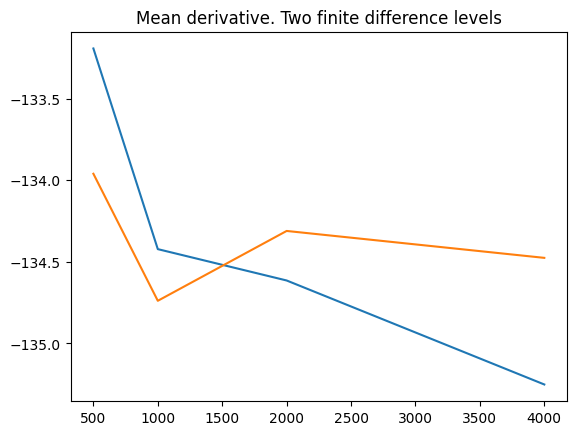

In [748]:
plt.plot(sizes, means0)
plt.plot(sizes, means1)
plt.title('Mean derivative. Two finite difference levels')

Text(0.5, 1.0, 'Variance of derivative')

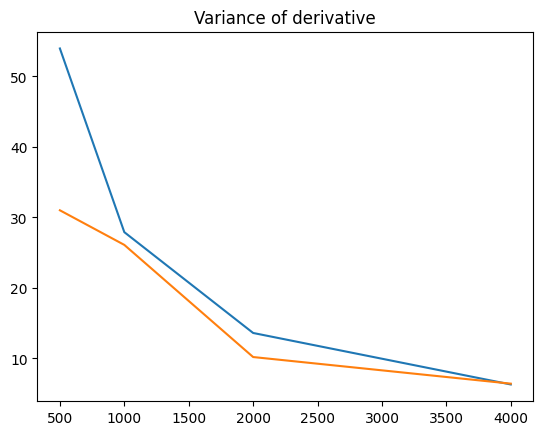

In [749]:
plt.plot(sizes, variances0 )
plt.plot(sizes, variances1 )
plt.title('Variance of derivative')

In [719]:
sizes = [500, 1000, 2000, 4000]

means0 = []
variances0 = []

for size in sizes:
    data = []
    for rep in range(50):
        data.append( estimate_deriv(size, 0.1).item() )
    means0.append( np.mean(data) )
    variances0.append( np.var(data) )

    print(size)


means1 = []
variances1 = []

for size in sizes:
    data = []
    for rep in range(50):
        data.append( estimate_deriv(size, 0.05).item() )
    means1.append( np.mean(data) )
    variances1.append( np.var(data) )

    print(size)

500
1000
2000
4000
500
1000
2000
4000


Text(0.5, 1.0, 'More samples: mean')

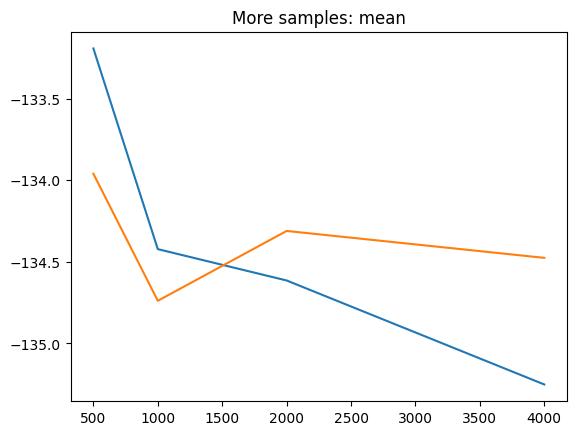

In [750]:
plt.plot(sizes, means0)
plt.plot(sizes, means1)
plt.title('More samples: mean')

Text(0.5, 1.0, 'More samples: variance of deriv')

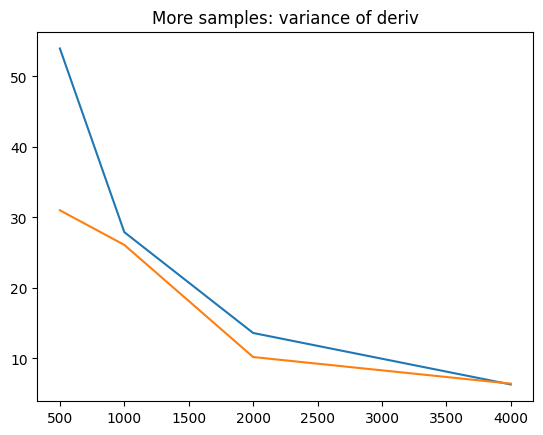

In [751]:
plt.plot(sizes, variances0 )
plt.plot(sizes, variances1 )
plt.title('More samples: variance of deriv')

#### Some observations worth making.
1. Even the large sample numbers run very quickly. This is probably because of the memory savings involved in using a shared underlying image.
2. The different finite difference approximations do make a small difference, but it is not enough to outweigh the noise in the estimates
3. There are, however, diminishing returns to using more datapoints, across scales. Double the number of datapoints give ~ half the variance.

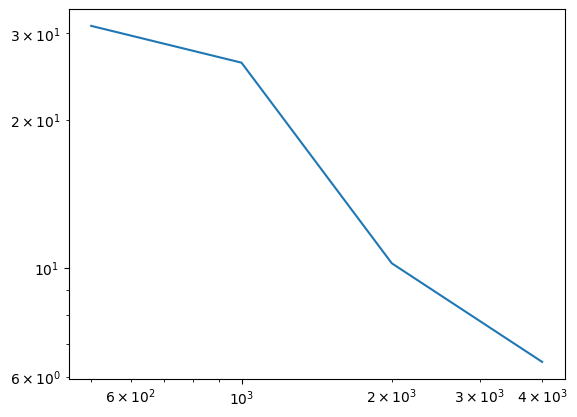

In [755]:
plt.loglog(sizes, variances1 )

In [759]:
def estimate_deriv_direct(size, image_delta):
    plus_I0 = FaceDataset(torch.zeros(80) + image_delta/2, split='test').images[0]
    minus_I0 = FaceDataset(torch.zeros(80) - image_delta/2, split='test').images[0]

    outs_plus = model.forward(plus_I0.repeat((size,1,1)).to(model.device))
    outs_minus = model.forward(minus_I0.repeat((size, 1, 1)).to(model.device))

    delta = outs_plus.mean(0).cpu() - outs_minus.mean(0).cpu()

    return delta[0] / image_delta

In [741]:
sizes = [500, 1000, 2000, 4000]

means_direct = []
variances_direct = []

for size in sizes:
    data = []
    for rep in range(50):
        data.append( estimate_deriv_direct(size, 0.1).item() )
    means_direct.append( np.mean(data) )
    variances_direct.append( np.var(data) )

    print(size)

500
1000
2000
4000


Text(0.5, 1.0, 'Direct differencing vs derivative evaluation: mean result')

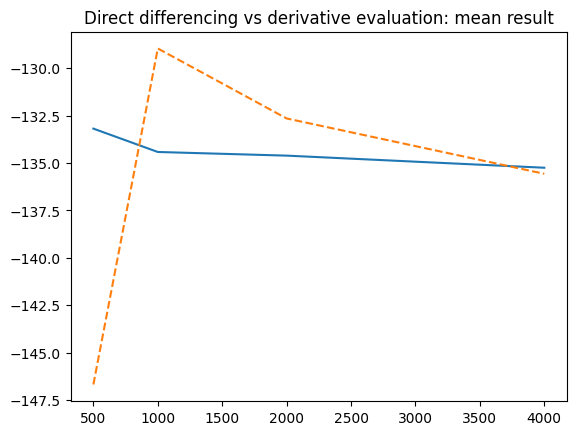

In [757]:
plt.plot(sizes, means0)
plt.plot(sizes, means_direct, '--')
plt.title('Direct differencing vs derivative evaluation: mean result')

Text(0.5, 1.0, 'Direct differencing vs derivative evaluation: result variance')

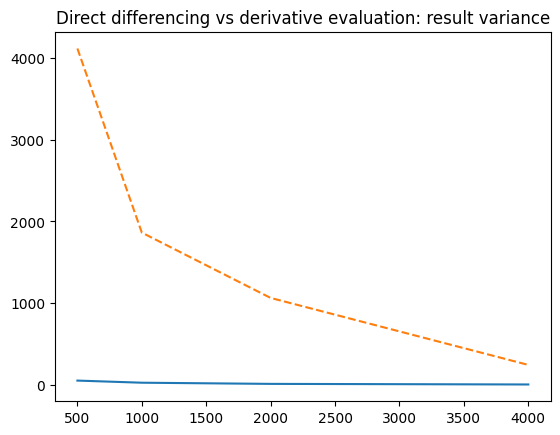

In [758]:
plt.plot(sizes, variances0)
plt.plot(sizes, variances_direct, '--')
plt.title('Direct differencing vs derivative evaluation: result variance')

#### Ok, this gives sizable savings.

In particular, the variance is massively lower when we evaluate the derivatives using the networks.

I think that I pretty much understand why this is happening from working through this notebook: the finite differences use the noisy outputs to compute derivatives, which are sensitive to the size of the finite differences and therefore require many samples to find good estimates. The derivatives, meanwhile, are essentially averaging over the network noise while computations are happening, both the derivatives, and the pixel-wise sum.

Nicely, the means do converge, with the direct estimate having variance of the mean:

In [746]:
variances_direct[-1] / 50

4.912764822744811

One downside of the using the derivative method to evaluation Fisher information is that we no longer get statistics on the variance of our estimator as we would while using means directly. However, we _can_ still use the samples that we use to estimate covariance matrix to determine the number of samples we need.

## tests of the FI function implemented this way

In [8]:
ckpt = 'trainedParameters/Exp8/dropout/linear/low_conc/rep0/epoch=571-step=146432.ckpt'
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

In [55]:
%run discriminationAnalysis.py

def Fisher_derivatives_faces_linear(model, thetas, num_samples=1000, image_delta=0.05):
    """ Direct evaluation of the Fisher information by taking derivatives of the neural
        networks.

        Written specifically for the face dataset.

        In notebook 2.2 I explore how empirically this approach is substantially 
        more statistically efficient that direct evaluation.
    """
    def point_Fisher(theta):
        """ This could definitely be sped up by vectorization in a variety of dimensions """
        I0 = FaceDataset(torch.zeros(80) + theta, split='test').images.contiguous()
        I0.requires_grad = True

        outputs = model.forward(I0.repeat((num_samples, 1, 1)).to(model.device)).cpu()
        model_grad0 = torch.autograd.grad(outputs.mean(0)[0], I0, retain_graph=True)[0]
        model_grad1 = torch.autograd.grad(outputs.mean(0)[1], I0)[0]

        plus_I0 = FaceDataset(torch.zeros(80) + theta + image_delta/2, split='test').images.contiguous()
        minus_I0 = FaceDataset(torch.zeros(80) + theta - image_delta/2, split='test').images.contiguous()
        image_deriv = (plus_I0 - minus_I0) / image_delta 

        full_deriv0 = (model_grad0 * image_deriv).sum().item()
        full_deriv1 = (model_grad1 * image_deriv).sum().item()
        douts = torch.tensor([full_deriv0, full_deriv1])

        cov = outputs.T.cov().detach()
        torch.mps.empty_cache()
        return (douts @ torch.linalg.inv(cov) @ douts).item()

    FIs = np.zeros(len(thetas))
    for i, theta in enumerate(thetas):
        FIs[i] = point_Fisher(theta)

    return FIs

Fisher_derivatives_faces = Fisher_derivatives_faces_linear

<Figure size 640x480 with 0 Axes>

In [6]:
FI = Fisher_derivatives_faces(model, np.linspace(0, 2*np.pi, 30))

In [7]:
FI2 = Fisher_derivatives_faces(model, np.linspace(0, 2*np.pi, 30), num_samples=2000, image_delta=0.01)
FI3 = Fisher_derivatives_faces(model, np.linspace(0, 2*np.pi, 30), num_samples=2000, image_delta=0.01)
FI4 = Fisher_derivatives_faces(model, np.linspace(0, 2*np.pi, 30), num_samples=100)

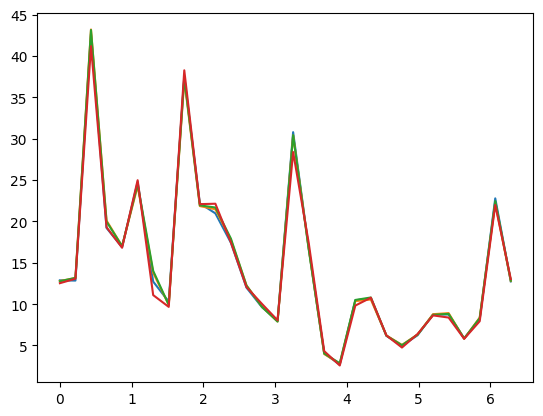

In [8]:
plt.plot(np.linspace(0, 2*np.pi, 30), FI)
plt.plot(np.linspace(0, 2*np.pi, 30), FI2)
plt.plot(np.linspace(0, 2*np.pi, 30), FI3)
plt.plot(np.linspace(0, 2*np.pi, 30), FI4)

In [11]:
FI2 == FI3

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

Huh. Ok so this is very bumpy, with only a quite weak larger trend. The replicates are very consistent, but not identical, which is what we want. Also nice to see is the fact that the first and last points are very close to each other.

In [9]:
ckpt = 'trainedParameters/Exp8/dropout/linear/high_conc/rep0/epoch=364-step=93440.ckpt'
model2 = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

Text(0.5, 1.0, 'Highly concentrated Fisher information')

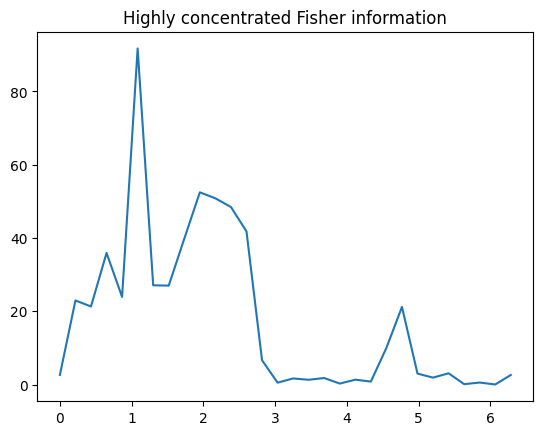

In [10]:
FI = Fisher_derivatives_faces(model2, np.linspace(0, 2*np.pi, 30))
plt.plot(np.linspace(0, 2*np.pi, 30), FI)
plt.title('Highly concentrated Fisher information')

Is this what we would expect ?
Well, yes: the Fisher information is concentrated near $\pi /2$.

It gets larger than the low concentration in high concentration areas, and smaller in low concnetration areas.

In [11]:
ckpt_low = 'trainedParameters/Exp8/dropout/linear/low_conc/rep0/epoch=571-step=146432.ckpt'
model_low = EstimateAngle_Faces_final.load_from_checkpoint(ckpt_low, loss_pair=('linear', lambda d:d))

ckpt_high = 'trainedParameters/Exp8/dropout/linear/high_conc/rep0/epoch=364-step=93440.ckpt'
model_high = EstimateAngle_Faces_final.load_from_checkpoint(ckpt_high, loss_pair=('linear', lambda d:d))

FI_low = Fisher_derivatives_faces(model_low, np.linspace(0, 2*np.pi, 100), num_samples=100)
FI_high = Fisher_derivatives_faces(model_high, np.linspace(0, 2*np.pi, 100), num_samples=100)

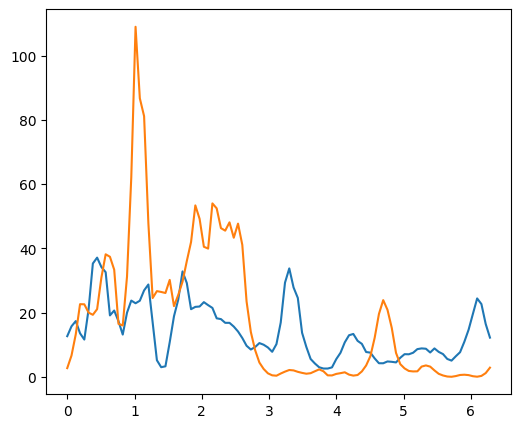

In [15]:
plt.plot(np.linspace(0, 2*np.pi, 100), FI_low)
plt.plot(np.linspace(0, 2*np.pi, 100), FI_high)

The learned Fisher informations are clearly not as smooth as the learned mean square errors.

## Covariances

How much does the covariance matrix change, and how does this impact the Fisher information?

In [13]:
I0 = FaceDataset(torch.zeros(80*80) + 0, split='test').images.contiguous()
I1 = FaceDataset(torch.zeros(80*80) + 0.1, split='test').images.contiguous()

In [14]:
model.forward(I0.to(model.device)).cpu().T.cov()

tensor([[10488.8398,   311.1424],
        [  311.1424,   463.3368]], grad_fn=<SqueezeBackward0>)

In [15]:
model.forward(I1.to(model.device)).cpu().T.cov()

tensor([[7289.5957,  536.8446],
        [ 536.8446,  293.2055]], grad_fn=<SqueezeBackward0>)

In [16]:
C0 = model.forward(I0.to(model.device)).cpu().T.cov()
C1 = model.forward(I1.to(model.device)).cpu().T.cov()

dC = (C1 - C0 )/0.1

C0i = torch.linalg.inv(C0)

In [17]:
torch.trace( C0i @ dC @ C0i @ dC )

tensor(31.2961, grad_fn=<TraceBackward0>)

This makes it seem like there is a large amount to be extracted from the changes in the covaraince matrix, which could also have quite a large impact on the Fisher info.

In [34]:
I0 = FaceDataset(torch.zeros(80) , split='test').images.contiguous()
I0.requires_grad = True

outputs = model.forward(I0.repeat((100, 1, 1)).to(model.device)).cpu()

In [56]:
def Fisher_derivatives_faces_covariance(model, thetas, num_samples=1000, image_delta=0.05):
    """ The covariance term in the Fisher information
        Evaluated by taking derivatives of the neural networks.

        Written specifically for the face dataset.
    """
    def point_Fisher(theta):
        """ This could definitely be sped up by vectorization in a variety of dimensions """
        I0 = FaceDataset(torch.zeros(80) + theta, split='test').images.contiguous()
        I0.requires_grad = True

        outputs = model.forward(I0.repeat((num_samples, 1, 1)).to(model.device)).cpu()
        cov = outputs.T.cov()
        model_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
        model_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
        model_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
        model_grad11 = torch.autograd.grad(cov[1,1], I0)[0]

        plus_I0 = FaceDataset(torch.zeros(80) + theta + image_delta/2, split='test').images.contiguous()
        minus_I0 = FaceDataset(torch.zeros(80) + theta - image_delta/2, split='test').images.contiguous()
        image_deriv = (plus_I0 - minus_I0) / image_delta 

        full_deriv00 = (model_grad00 * image_deriv).sum().item()
        full_deriv01 = (model_grad10 * image_deriv).sum().item()
        full_deriv10 = (model_grad10 * image_deriv).sum().item()
        full_deriv11 = (model_grad11 * image_deriv).sum().item()

        dCov = torch.tensor([[full_deriv00, full_deriv01], [full_deriv10, full_deriv11]])
        cov = cov.detach()
        invcov = torch.linalg.inv(cov)
        torch.mps.empty_cache()
        return 0.5 * torch.trace(invcov @ dCov @ invcov @ dCov)

    FIs = np.zeros(len(thetas))
    for i, theta in enumerate(thetas):
        FIs[i] = point_Fisher(theta)

    return FIs


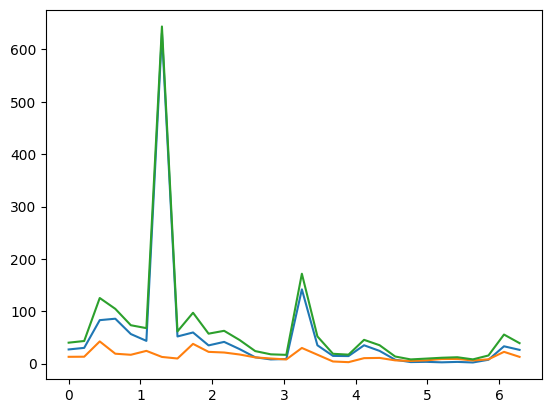

In [54]:
FI_cov = Fisher_derivatives_faces_covariance(model, np.linspace(0, 2*np.pi, 30))
FI_lin = Fisher_derivatives_faces_linear(model,np.linspace(0, 2*np.pi, 30))

plt.plot( np.linspace(0, 2*np.pi, 30), FI_cov)
plt.plot( np.linspace(0, 2*np.pi, 30), FI_lin)
plt.plot( np.linspace(0, 2*np.pi, 30), FI_cov + FI_lin)

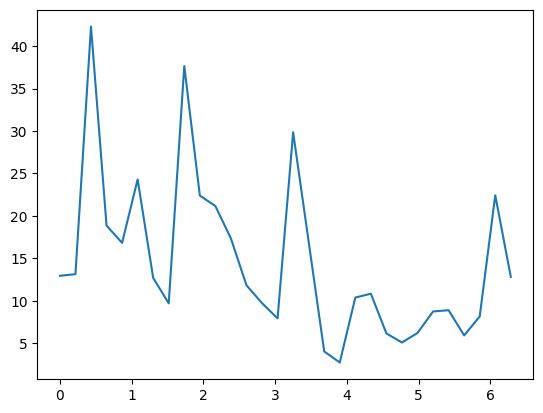

In [55]:
plt.plot( np.linspace(0, 2*np.pi, 30), FI_lin)

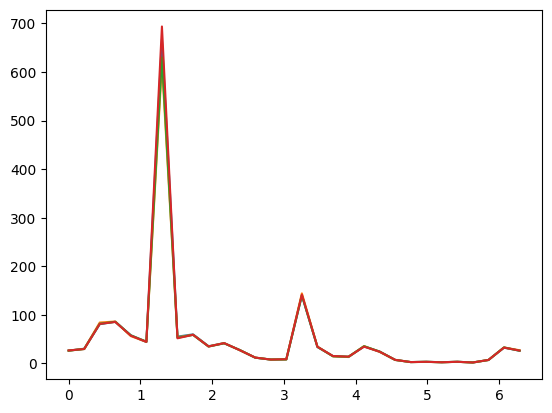

In [114]:
for rep in range(4):
    angles = np.linspace(0, 2*np.pi, 30)
    FI_cov = Fisher_derivatives_faces_covariance(model, angles)
    plt.plot(angles, FI_cov)

Pretty consistent.

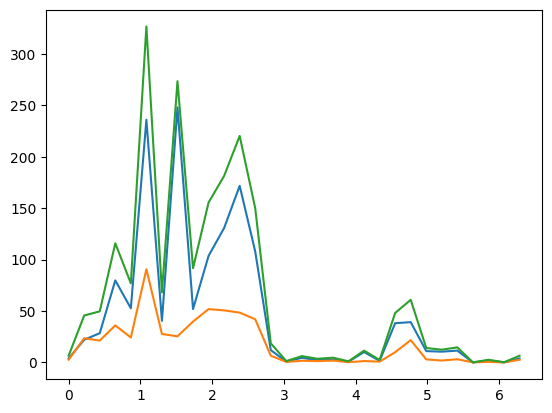

In [50]:
FI_cov = Fisher_derivatives_faces_covariance(model_high, np.linspace(0, 2*np.pi, 30))
FI_lin = Fisher_derivatives_faces_linear(model_high,np.linspace(0, 2*np.pi, 30))

plt.plot( np.linspace(0, 2*np.pi, 30), FI_cov)
plt.plot( np.linspace(0, 2*np.pi, 30), FI_lin)
plt.plot( np.linspace(0, 2*np.pi, 30), FI_cov + FI_lin)

Ok. The covarinace Fisher information appears to dwarf the Fisher information due to mean changes.
They have similar large-scale structure, but the cov is still so much bigger.

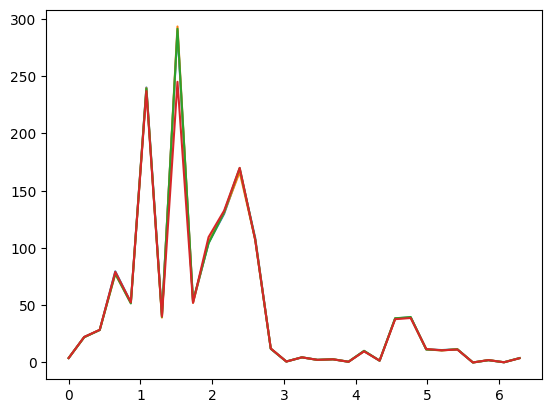

In [58]:
for i in range(4):
    FI_cov = Fisher_derivatives_faces_covariance(model_high, np.linspace(0, 2*np.pi, 30))
    plt.plot( np.linspace(0, 2*np.pi, 30), FI_cov)

Resonably noise free.

#### What is happening with those spikes in the low concentration model?

In [108]:
FI_cov_low = Fisher_derivatives_faces_covariance(model, np.linspace(0, 2*np.pi, 30))

In [109]:
print(FI_cov_low[6], np.linspace(0, 2*np.pi, 30)[6])

722.966552734375 1.2999693738992248


In [110]:
I_pre = FaceDataset(torch.zeros(500) + 1.3 - 0.1, split='test').images.contiguous()
outs_pre = model.forward(I_pre.repeat((10,1,1)).to(model.device)).cpu().detach()

I_post = FaceDataset(torch.zeros(500) + 1.3 + 0.1 , split='test').images.contiguous()
outs_post = model.forward(I_post.repeat((10,1,1)).to(model.device)).cpu().detach()

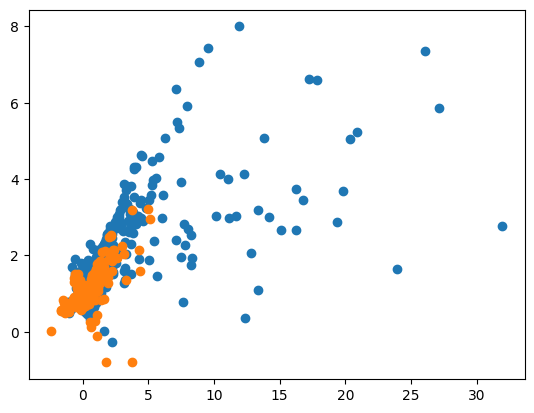

In [111]:
plt.scatter(outs_pre[:,0], outs_pre[:,1])
plt.scatter(outs_post[:,0], outs_post[:,1])

In [112]:
outs_pre.T.cov()

tensor([[2.0935, 0.5476],
        [0.5476, 0.2757]])

In [113]:
outs_post.T.cov()

tensor([[0.0759, 0.0256],
        [0.0256, 0.0254]])

Interestingly, this drastic change in Fisher information appears to be due to a very low variance region of the input space.

### Lets double check the covariance calculations

In [5]:
ckpt = 'trainedParameters/Exp8/dropout/linear/low_conc/rep0/epoch=571-step=146432.ckpt'
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

In [81]:
def find_dcov():
    I0 = FaceDataset(torch.zeros(80), split='test').images[0]
    I0.requires_grad = True
    
    Ip = FaceDataset(torch.zeros(80)+0.05, split='test').images[0]
    Im = FaceDataset(torch.zeros(80)-0.05, split='test').images[0]
    image_deriv = (Ip - Im )/ 0.1
    
    outputs = model.forward(I0.repeat((1000, 1, 1)).to(model.device)).cpu()
    cov = outputs.T.cov()
    
    cov_grad00 = torch.autograd.grad(cov[0,0], I0, retain_graph=True)[0]
    cov_grad01 = torch.autograd.grad(cov[0,1], I0, retain_graph=True)[0]
    cov_grad10 = torch.autograd.grad(cov[1,0], I0, retain_graph=True)[0]
    cov_grad11 = torch.autograd.grad(cov[1,1], I0)[0]
    
    cov_deriv00 = (cov_grad00 * image_deriv).sum().item()
    cov_deriv01 = (cov_grad10 * image_deriv).sum().item()
    cov_deriv10 = (cov_grad10 * image_deriv).sum().item()
    cov_deriv11 = (cov_grad11 * image_deriv).sum().item()
    dCov = torch.tensor([[cov_deriv00, cov_deriv01], [cov_deriv10, cov_deriv11]])
    torch.cuda.empty_cache()
    return dCov

In [82]:
computed_diffs = []
for rep in range(100):
    computed_diffs.append(find_dcov())

computed_diffs = torch.stack(computed_diffs)

In [83]:
sampled_diffs = []

for rep in range(500):
    out_p = model.forward(Ip.repeat((10000, 1, 1)).to(model.device)).cpu().detach()
    out_m = model.forward(Im.repeat((10000, 1, 1)).to(model.device)).cpu().detach()

    cov_diff = (out_p.T.cov() - out_m.T.cov()) /0.1
    sampled_diffs.append(cov_diff.detach())
    torch.cuda.empty_cache()

sampled_diffs = torch.stack(sampled_diffs)

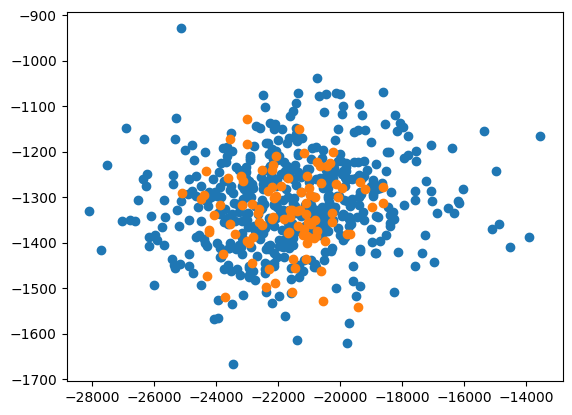

In [84]:
plt.scatter(sampled_diffs[:,0,0], sampled_diffs[:, 1,1])
plt.scatter(computed_diffs[:,0,0], computed_diffs[:, 1,1])


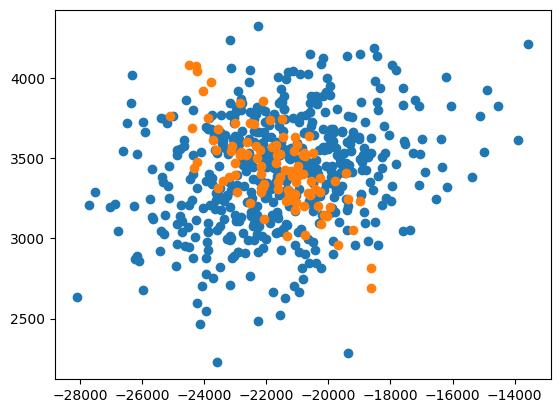

In [85]:
plt.scatter(sampled_diffs[:,0,0], sampled_diffs[:, 0,1])
plt.scatter(computed_diffs[:,0,0], computed_diffs[:, 0,1])

Overall, this seems consistent. However, the computed differences are more variable than I would have guessed

## Domain dependence

I've noticed that small changes in the domain result in large changes in the Fisher information. This seems to indicate that the FI is very unsmooth....

In [57]:
%run discriminationAnalysis.py
ckpt = 'trainedParameters/Exp8/dropout/linear/low_conc/rep0/epoch=571-step=146432.ckpt'
model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

Fisher_derivatives_faces_total = Fisher_derivatives_faces

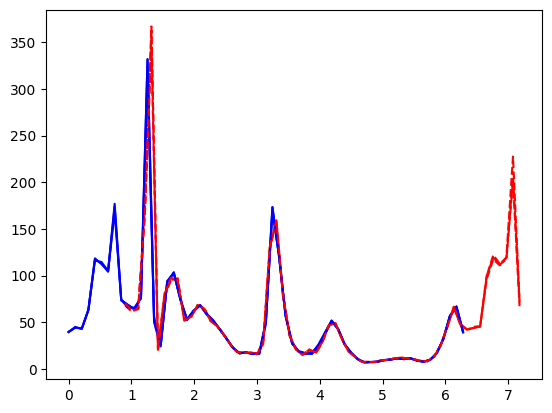

In [16]:
baseline = np.linspace(0, 2*np.pi, 61)
jitter = baseline + 0.9

for rep in range(3):
    FI_base = Fisher_derivatives_faces_total(model, baseline)
    FI_jitter = Fisher_derivatives_faces_total(model, jitter)

    plt.plot(baseline, FI_base, 'b')
    plt.plot(jitter, FI_jitter, '--r')

Yes indeed, the Fisher information seems to be quite unsmooth. There is little varaince in the Fisher information measurements that we obtain, but still a great deal of variance when we change the locations where we are sampling.

# Handling domain dependence

## Summing up Fisher information over small-scales


In [4]:
from scipy import integrate

In [5]:
%run discriminationAnalysis.py
model

EstimateAngle_Faces_final(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=30, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=30, out_features=10, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
  (cosSim): CosineSimilarity()
)

In [6]:
FIs = []
for rep in range(5):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0, 0.1, 15), num_samples=1000)
    FIs.append(FI)
    print(rep)

0
1
2
3
4


In [7]:
FIs2 = []
for rep in range(5):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0.01, 0.11, 15), num_samples=1000)
    FIs2.append(FI)
    print(rep)

0
1
2
3
4


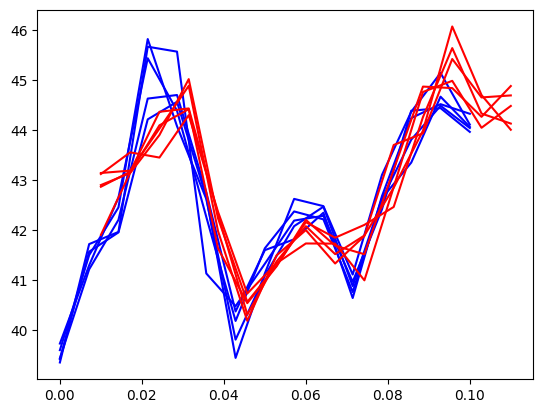

In [8]:
for FI in FIs:
    plt.plot(np.linspace(0, 0.1, 15), FI, 'b')

for FI in FIs2:
    plt.plot(np.linspace(0.01, 0.11, 15), FI, 'r')

This re-iterates what we saw earlier with the great variability between different inputs. There is also a degree of noise in the curves. 

In [9]:
FIs = []
for rep in range(7):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0, 0.1, 25), num_samples=1000)
    FIs.append(FI)
    print(rep)

0
1
2
3
4
5
6


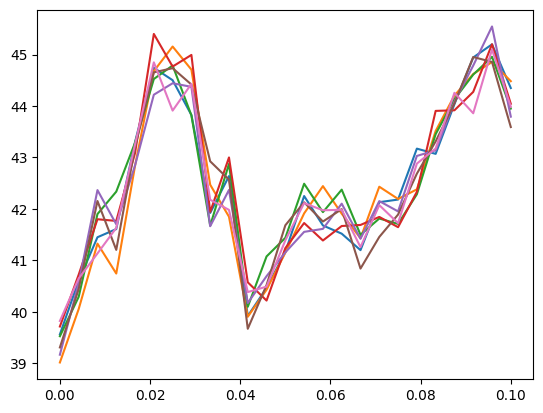

In [10]:
for FI in FIs:
    plt.plot(np.linspace(0, 0.1, 25), FI)

In [11]:
FIs = []
for rep in range(7):
    FI = Fisher_derivatives_faces_optimized(model, np.linspace(0, 0.1, 25), num_samples=2000)
    FIs.append(FI)
    print(rep)

0
1
2
3
4
5
6


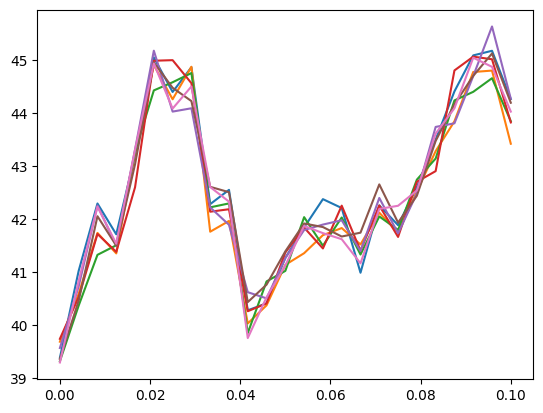

In [12]:
for FI in FIs:
    plt.plot(np.linspace(0, 0.1, 25), FI)

Doubling the number of samples does reduce the noise variance somewhat, but not all that significantly.

This noise is an argument for simple integration rules, which look more like averaging the input points.

### How much do these measurements vary if we change the sampling positions?

One thing to do is to simply sample randomly along the interval, so that the variance between results reflects the variance in sampling location. 

Random sampling has the appealing properties of:
1. unbiasedness with regard to locations
2. providing an error estimate from the variance (alternatively, bootstrap variance) of the sample results
3. ease of scaling to better results by increasing the number of samples

In [13]:
def FI_approximation(n, t0, t1):
    deltat = t1 - t0
    positions = t0 + deltat * np.random.randn(n)
    FIs = Fisher_derivatives_faces_optimized(model, positions)
    return FIs.mean()

In [18]:
interval_FIs = []
for rep in range(30):
    interval_FIs.append( FI_approximation(10, 0, 0.1) )

(array([1., 4., 3., 5., 2., 4., 4., 3., 3., 1.]),
 array([49.17431183, 49.2339904 , 49.29366898, 49.35334755, 49.41302612,
        49.4727047 , 49.53238327, 49.59206184, 49.65174042, 49.71141899,
        49.77109756]),
 <BarContainer object of 10 artists>)

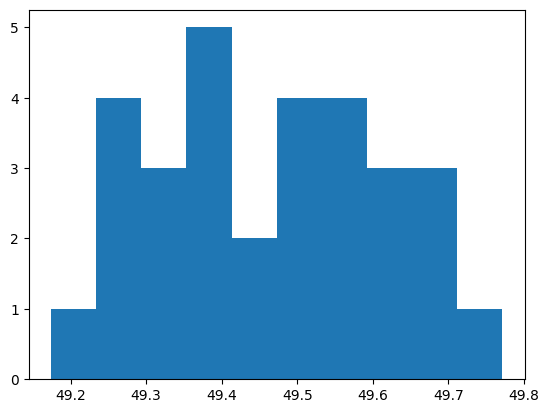

In [19]:
plt.hist( interval_FIs)

Like, yeah, this seems super reasonable.

In [20]:
from scipy.stats import bootstrap

In [86]:
%%time
positions = -0.1 * np.random.rand(80)
FIs = Fisher_derivatives_faces_optimized(model, positions)

CPU times: user 1min 11s, sys: 4min 12s, total: 5min 23s
Wall time: 47.8 s


In [87]:
%%time
positions = -0.1 * np.random.rand(40)
FIs = Fisher_derivatives_faces_optimized(model, positions)
FIs = Fisher_derivatives_faces_optimized(model, positions)

CPU times: user 1min 9s, sys: 4min 9s, total: 5min 18s
Wall time: 48.1 s


In [92]:
bootstrap(FIs[None,:], np.mean).standard_error

1.299729738956658

In [91]:
FIs[None, :]

array([[43.04088593, 49.00487518, 62.38668823, 63.68878937, 43.56956863,
        42.78151321, 43.57802582, 43.91822052, 42.56387329, 54.14487457,
        44.42854309, 56.1068573 , 43.31437302, 57.54154587, 44.10065079,
        44.17839432, 61.83827209, 42.50647354, 58.4226799 , 45.1326561 ,
        44.20446396, 44.67366028, 61.46324921, 54.33577728, 47.75114059,
        54.22566605, 53.46908188, 44.50848389, 62.0674057 , 64.58769226,
        53.52254105, 62.27751541, 63.05988312, 62.52740479, 63.2686615 ,
        41.09822464, 53.64351654, 44.02298355, 63.20201874, 43.20465851]])

In [89]:
FIs.mean()

51.68404474258423

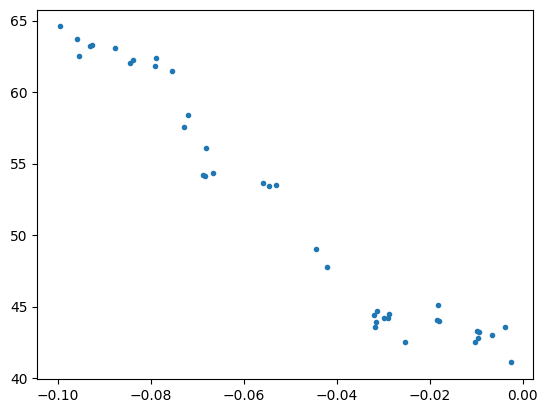

In [90]:
plt.plot(positions, FIs, '.')

## Trying out the integral formulation of the Fisher information

In [24]:
%run discriminationAnalysis.py

<Figure size 640x480 with 0 Axes>

In [5]:
nodes, FI = Full_Fisher_direct(model, np.linspace(0, 2*np.pi, 50) )

20 (0.0, 0.1282282715750936) 0.34313015237548583
20 (0.1282282715750936, 0.2564565431501872) 0.2872571760936604
20 (0.2564565431501872, 0.38468481472528077) 4.16954347602497
232
20 (0.2564565431501872, 0.32057067893773394) 1.6140149761253137
62
62 (0.2564565431501872, 0.32057067893773394) 1.066970701497225
73
73 (0.2564565431501872, 0.32057067893773394) 0.9553163471257329
20 (0.32057067893773394, 0.38468481472528077) 2.319620096403935
49
49 (0.32057067893773394, 0.38468481472528077) 1.5038201160271982
20 (0.38468481472528077, 0.5129130863003744) 1.1317876409619396
20 (0.5129130863003744, 0.6411413578754679) 2.048469597286775
20 (0.6411413578754679, 0.7693696294505615) 8.793913678640743
213
20 (0.6411413578754679, 0.7052554936630147) 2.4523193945482964
35
35 (0.6411413578754679, 0.7052554936630147) 2.1247831042601786
20 (0.7052554936630147, 0.7693696294505615) 7.245723775021677
91
91 (0.7052554936630147, 0.7693696294505615) 3.3920550674734744
20 (0.7693696294505615, 0.8975979010256552) 

In [24]:
baseline = np.linspace(0, 2*np.pi, 100)
FI_base = Fisher_derivatives_faces(model, baseline)

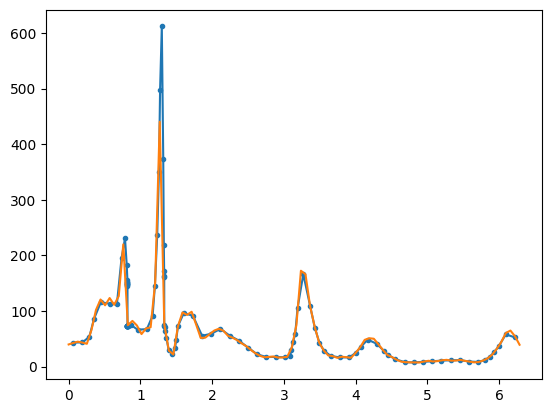

In [29]:
plt.plot(nodes, FI, '.-')
plt.plot(baseline, FI_base)

#### In summary

This approach is nice because it captures the very large Fisher information changes well, and guarantees the error bars. 

However, in exchange, it is very very expensive, and doesn't give us much additional insight at other, normal locations that is not captured by a fine sampling.

It is probably better is to simply sample more finely wherever there are large changes in the Fisher info.

### 'Happy medium' method: evalute subintervals until the Fisher information differences are small enough

In [4]:
%run discriminationAnalysis.py

#### 1
Applying this approach, we see that there are points that, I think, are just pure discontinuities. In particular, near 0.8199845, the algorithm just keeps dividing into smaller and smaller intervals.

This doesn't necessarily kill the sampling approach, which can also adapt by sampling more points, and thereby overcome discontinuities that are reasonably small. However, I do remember that that approach also struggled at this same spot.

I think the answer is to put a limit on how small we are willing to subdivide the intervals.

#### 2
There is also the question of the level of noise, which seems to scale upward with the size of the Fisher information. To address this, we can limit the fold changes, rather that absolute changes.

Predictably, this adds a lot of points where the Fisher information is small, even though the changes are small. In other words, because the noise seems to be proportional to the Fisher information itself, using a fold threashold means that we have to fight with the noise across the whole range of Fisher information values.

I'll just use both, and accept if either holds. This works as expected: small absolute differences dominate at small Fisher information, which small fold differences dominate at large Fisher information.

In [5]:
thetas, FIs = Full_Fisher_max_delta(model, np.linspace(0, 2*np.pi, 60), Fisher_derivatives_faces)

In [6]:
baseline = np.linspace(0, 2*np.pi, 100)
FI_base = Fisher_derivatives_faces(model, baseline)

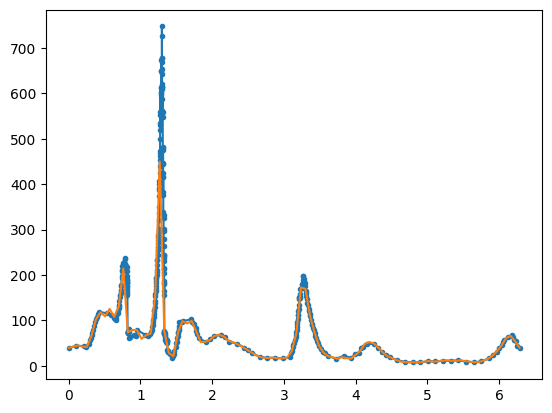

In [7]:
plt.plot(thetas, FIs, '.-')
plt.plot(baseline, FI_base)

In [8]:
len(thetas)

374

## Checking out the network replicates

Text(0.5, 1.0, 'Fisher information: low concentration')

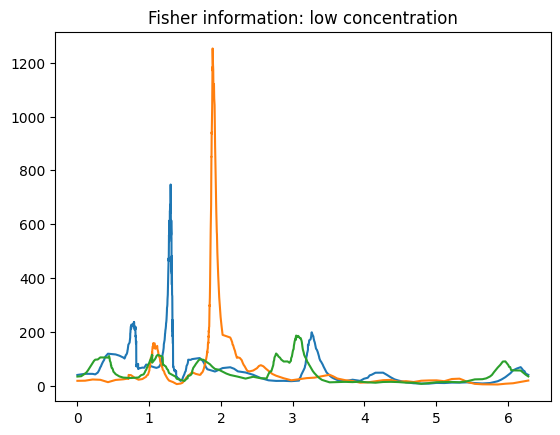

In [9]:
for rep in range(3):
    ckpt = glob.glob(f'trainedParameters/Exp8/dropout/linear/low_conc/rep{rep}/epoch*')[0]
    model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
    baseline = np.linspace(0, 2*np.pi, 60)
    thetas, FI = Full_Fisher_max_delta(model, baseline, Fisher_derivatives_faces)
    plt.plot(thetas, FI)

plt.title('Fisher information: low concentration')

Text(0.5, 1.0, 'Fisher information: high concentration')

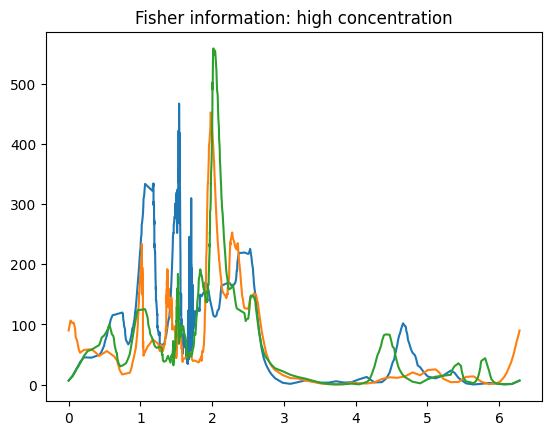

In [10]:
for rep in range(3):
    ckpt = glob.glob(f'trainedParameters/Exp8/dropout/linear/high_conc/rep{rep}/epoch*')[0]
    model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
    baseline = np.linspace(0, 2*np.pi, 60)
    thetas, FI = Full_Fisher_max_delta(model, baseline, Fisher_derivatives_faces)
    plt.plot(thetas, FI)

plt.title('Fisher information: high concentration')

Text(0.5, 1.0, 'Fisher information: uniform')

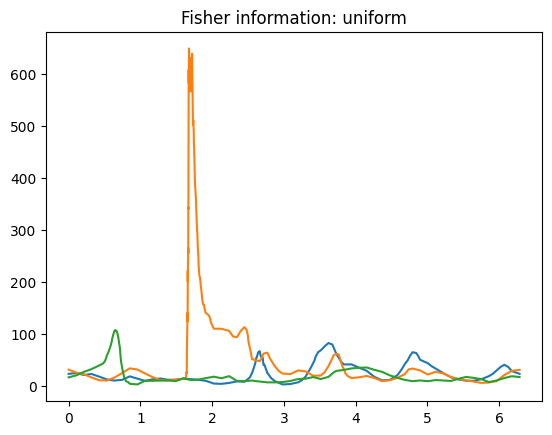

In [11]:
for rep in range(3):
    ckpt = glob.glob(f'trainedParameters/Exp8/dropout/linear/uniform/rep{rep}/epoch*')[0]
    model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))
    
    baseline = np.linspace(0, 2*np.pi, 60)
    thetas, FI = Full_Fisher_max_delta(model, baseline, Fisher_derivatives_faces)
    plt.plot(thetas, FI)

plt.title('Fisher information: uniform')

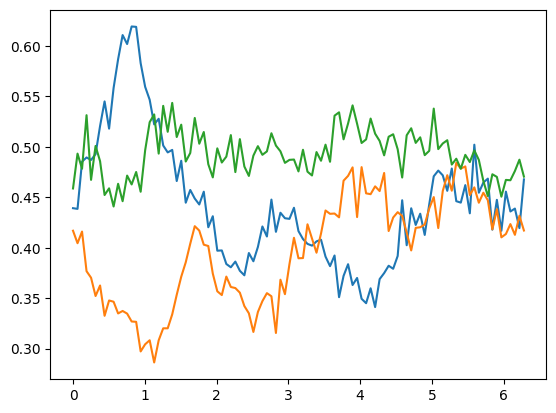

In [12]:
thetas = torch.linspace(0, 2*np.pi, 101).repeat(1000,1)
thetas = thetas.reshape(-1)
theta_plot = thetas.reshape((1000, 101)).mean(dim=0)

stimuli = FaceDataset(thetas, split='test').images.contiguous()

cos_sim = torch.nn.CosineSimilarity()

def find_error(model):
    outputs = model.forward(stimuli.to(model.device)).cpu()
    encoded_inputs = model.encodeAngles(thetas)

    sim = cos_sim(outputs, encoded_inputs).reshape(1000, 101).mean(dim=0)
    error = torch.arccos(torch.minimum(sim, torch.ones(sim.shape)))
    return error.detach().numpy()
    
for rep in range(3):
    ckpt = glob.glob(f'trainedParameters/Exp8/dropout/linear/uniform/rep{rep}/epoch*')[0]
    
    model = EstimateAngle_Faces_final.load_from_checkpoint(ckpt, loss_pair=('linear', lambda d:d))

    plt.plot(theta_plot, find_error(model))
    

There does seem to be a reverse correlation between the MSE and the Fisher information that we measure. However, interestingly, the massive spike in Fisher information does not seem to align with any features of the MSE.

Could this be a result of a changing covariance, which is not accessible to a linear readout? This aligns with what we saw earlier when comparing Fisher information with and without the covariance contribution: the covariance contribution gave large, localized spikes in the Fisher information. Moreover, these spikes appeared to result from a change in the covariance from having one large component to all small components, oblong to circular.

To be continued in the next notebook.